In [1]:
import os
import cv2
import random
import pickle
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import shutil
import itertools
import imutils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

In [2]:
def preprocess(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    return new_image

In [3]:
datadir = ['brain_tumor_dataset/','augmented_brain_tumor_dataset/']
CATEGORIES = ['no','yes']
training_data_feature = []
training_data_label = []
IMG_SIZE = 120

def create_training_data():
    for DATADIR in datadir:
        for category in CATEGORIES:
            path = os.path.join(DATADIR, category)
            class_num = CATEGORIES.index(category) # categories for dog(0) and cat(1)
            for img in tqdm(os.listdir(path)):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    image = preprocess(img_array)
                    new_array = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
                    new_array = new_array/255.0
                    training_data_feature.append(new_array)
                    training_data_label.append(class_num)
                except Exception as e:
                    pass
        
create_training_data()

100%|██████████| 10492/10492 [00:35<00:00, 293.81it/s]


(120, 120, 3)

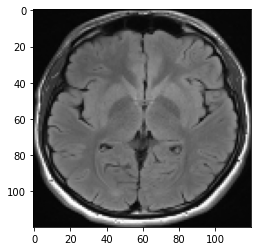

In [4]:
training_data_feature = np.array(training_data_feature)
training_data_label = np.array(training_data_label)
plt.imshow(training_data_feature[20])
training_data_feature[20].shape

In [5]:
X_train, X_test, y_train, y_test = train_test_split(training_data_feature,training_data_label, test_size=0.05)

# RESNET

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image

In [7]:
modelRes = Sequential()
modelRes.add(ResNet50(include_top=False,pooling='avg', weights="imagenet"))
modelRes.add(Flatten())
modelRes.add(Dense(1024, activation='relu'))
modelRes.add(Dropout(0.2))
modelRes.add(Dense(1, activation='sigmoid'))
#modelRes.layers[0].trainable = False
for i in range(len(modelRes.layers)):
        modelRes.layers[i].trainable = False
modelRes.layers[-1].trainable=True

# Compile model 
modelRes.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94773248/94765736 [==============================] - 23s 0us/step


In [8]:
modelRes.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 25,686,913
Trainable params: 1,025
Non-trainable params: 25,685,888
_________________________________________________________________


In [9]:
modelRes.fit(X_train,y_train,validation_split=0.2, epochs=5)

Epoch 1/5
677/677 [==============================] - 510s 750ms/step - loss: 0.6796 - accuracy: 0.5760 - val_loss: 0.6573 - val_accuracy: 0.6027
Epoch 2/5
677/677 [==============================] - 507s 749ms/step - loss: 0.6623 - accuracy: 0.5917 - val_loss: 0.6400 - val_accuracy: 0.6247
Epoch 3/5
677/677 [==============================] - 516s 762ms/step - loss: 0.6519 - accuracy: 0.6074 - val_loss: 0.6374 - val_accuracy: 0.6273
Epoch 4/5
677/677 [==============================] - 520s 769ms/step - loss: 0.6417 - accuracy: 0.6294 - val_loss: 0.6306 - val_accuracy: 0.6456
Epoch 5/5
677/677 [==============================] - 514s 759ms/step - loss: 0.6385 - accuracy: 0.6323 - val_loss: 0.6232 - val_accuracy: 0.6493


In [10]:
scores = modelRes.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

45/45 [==============================] - 26s 568ms/step - loss: 0.6310 - accuracy: 0.6393
Test loss: 0.6309932470321655
Test accuracy: 0.6392982602119446


/Users/egemenakbal/opt/miniconda3/envs/tfp-gpu/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0], dtype=int32)

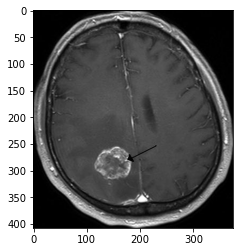

In [11]:
test_image = cv2.imread('test/arifk1.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0

plt.imshow(test_image)

test_image = np.array(new_array)
X_test[0]=test_image
ynew = modelRes.predict_classes(X_test)
ynew[0]